In [1]:
import numpy as np
import dapy.filters as filters
import dapy.utils.pou as pou
from dapy.models.damped_advection import SpatialDampedAdvectionModel
from dapy.utils.plotting import (
    plot_rank_histogram, 
    animate_2d_fields, 
    plot_slices_through_time, 
    plot_slices_through_space
)
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['animation.html'] = 'html5'

In [2]:
model_params = {
    'spatial_mesh_shape': (50, 50),
    'time_step': 1.,
    'observation_grid_shape': (10, 10),
    'domain_size': (1., 1.),
    'state_noise_length_scale': 0.0707,
    'state_noise_amplitude': 5.,
    'advection_coeff': (0.0625, 0.0625),
    'damping_coeff': np.log(2) / 2,
    'observation_noise_std': 1.,
    'observation_function': lambda x, t: x / np.tanh(x * 10)
}
model = SpatialDampedAdvectionModel(**model_params)

In [3]:
observation_time_indices = np.arange(0, 200)
seed = 20220302
rng = np.random.default_rng(seed)
state_sequence, observation_sequence = model.sample_state_and_observation_sequences(
    rng, observation_time_indices, return_states_at_all_times=False
)

Sampling: 100%|██████████|200/200 [00:00<00:00, 406.45time-steps/s]

In [4]:
localisation_radius = 0.2
ensemble_filter = filters.ScalableLocalEnsembleTransformParticleFilter(
    localisation_radius=localisation_radius, 
    partition_of_unity=pou.SmoothedBlock2dPartitionOfUnityBasis(
        model, (10, 10), kernel_halfwidth=3, use_distance_from_patch_center=True
    ),
    optimal_transport_solver_kwargs={'num_thread': 4},
    calculate_cost_matrices_func_kwargs={'num_thread': 4}
)

In [5]:
results_per_num_particle = {}
num_particle_grid = np.array([100, 200, 400, 800])
for num_particle in num_particle_grid:
    print(f'Number of particles = {num_particle}')
    results_per_num_particle[num_particle] = []
    for seed in np.random.SeedSequence(2422663217).spawn(5):
        rng = np.random.default_rng(seed)
        results_per_num_particle[num_particle].append(ensemble_filter.filter(
            model=model, 
            observation_sequence=observation_sequence, 
            observation_time_indices=observation_time_indices, 
            num_particle=num_particle, 
            rng=rng, 
            return_particles=False
        ))

Number of particles = 100


Filtering: 100%|██████████|200/200 [01:25<00:00, 2.35time-steps/s]

Filtering: 100%|██████████|200/200 [01:11<00:00, 2.81time-steps/s]

Filtering: 100%|██████████|200/200 [01:09<00:00, 2.87time-steps/s]

Filtering: 100%|██████████|200/200 [01:10<00:00, 2.85time-steps/s]

Filtering: 100%|██████████|200/200 [01:10<00:00, 2.85time-steps/s]

Number of particles = 200


Filtering: 100%|██████████|200/200 [04:15<00:00, 1.28s/time-steps]

Filtering: 100%|██████████|200/200 [04:15<00:00, 1.28s/time-steps]

Filtering: 100%|██████████|200/200 [04:16<00:00, 1.28s/time-steps]

Filtering: 100%|██████████|200/200 [04:15<00:00, 1.28s/time-steps]

Filtering: 100%|██████████|200/200 [04:15<00:00, 1.28s/time-steps]

Number of particles = 400


Filtering: 100%|██████████|200/200 [16:45<00:00, 5.03s/time-steps]

Filtering: 100%|██████████|200/200 [16:47<00:00, 5.04s/time-steps]

Filtering: 100%|██████████|200/200 [16:50<00:00, 5.05s/time-steps]

Filtering: 100%|██████████|200/200 [16:47<00:00, 5.04s/time-steps]

Filtering: 100%|██████████|200/200 [16:49<00:00, 5.05s/time-steps]

Number of particles = 800


Filtering: 100%|██████████|200/200 [1:10:20<00:00, 21.10s/time-steps]

Filtering: 100%|██████████|200/200 [1:10:08<00:00, 21.04s/time-steps]

Filtering: 100%|██████████|200/200 [1:10:05<00:00, 21.03s/time-steps]

Filtering: 100%|██████████|200/200 [1:10:09<00:00, 21.05s/time-steps]

Filtering: 100%|██████████|200/200 [1:10:07<00:00, 21.04s/time-steps]

In [20]:
for num_particle, results_list in results_per_num_particle.items():
    np.savez(
        f'damped-advection-{num_particle}-particle-results.npz', 
        state_mean_sequence=np.stack(r['state_mean_sequence'] for r in results_list),
        state_std_sequence=np.stack(r['state_std_sequence'] for r in results_list),
    )

/home/matt/miniconda3/envs/dapy/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [11]:
rmse_in_mean_estimate = np.array(
    [[((results['state_mean_sequence']**2).mean())**0.5 for results in results_list] for results_list in results_per_num_particle.values()]
)

In [14]:
plt.rcParams.update({
    'mathtext.fontset': 'cm',
    'font.family': 'Latin Modern Roman',
    'text.usetex': True,
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 10,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.75,
    'grid.linewidth': 0.5,
    'axes.labelpad': 2.,
    'figure.dpi': 150,
    'animation.html': 'html5'
})

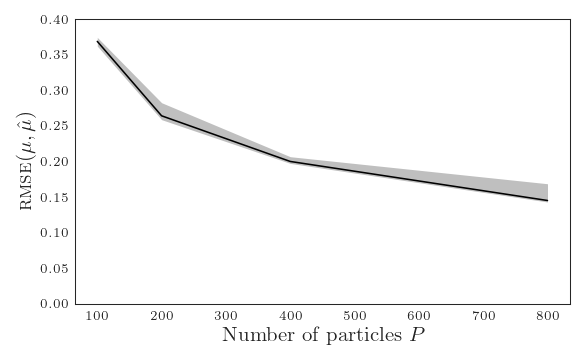

In [19]:

fig, ax = plt.subplots(figsize=(4, 2.5))
ax.fill_between(
    num_particle_grid, 
    np.min(rmse_in_mean_estimate, -1),
    np.max(rmse_in_mean_estimate, -1),
    alpha=0.5,
    facecolor='gray',
    edgecolor='gray',
    lw=0,
)
ax.plot(
    num_particle_grid, 
    np.median(rmse_in_mean_estimate, -1),
    '-',
    color='black'
)
ax.set_xlabel('Number of particles $P$')
ax.set_ylabel('$\\textsc{{rmse}}(\\mu,\\hat{{\\mu}})$')
ax.set_ylim(0, 0.4)
fig.tight_layout()
fig.savefig('damped-advection-model-num-particles.pdf')